# Probability of Failure Estimation with Gaussian Processes

In [1]:
!pip install botorch -U --quiet

In [2]:
import qmcpy as qp
import numpy as np
import scipy.stats
import gpytorch
import torch
import os
import warnings
import pandas as pd
from gpytorch.utils.warnings import NumericalWarning
warnings.filterwarnings("ignore")
pd.set_option(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', 1000,
    'display.colheader_justify', 'center',
    'display.precision',2,
    'display.float_format',lambda x:'%.1e'%x)
from matplotlib import pyplot,gridspec
pyplot.style.use("../qmcpy/qmcpy.mplstyle")

In [3]:
import pandas as pd 
pd.set_option(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', 1000,
    'display.colheader_justify', 'center',
    'display.precision',2,
    'display.float_format',lambda x:'%.1e'%x)
from matplotlib import pyplot
pyplot.style.use("../qmcpy/qmcpy.mplstyle")

In [4]:
gpytorch_use_gpu = torch.cuda.is_available()
gpytorch_use_gpu

False

## Method Visual

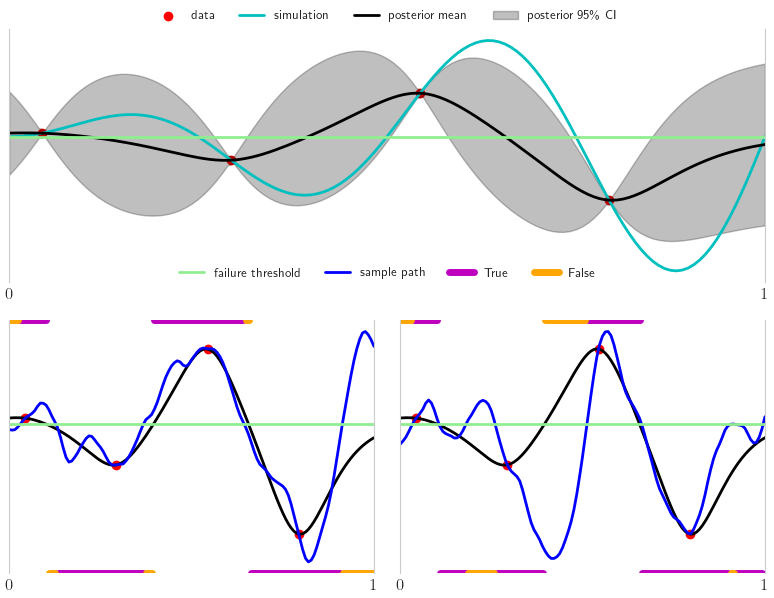

In [5]:
cols = 2
nticks = 129
np.random.seed(7); torch.manual_seed(1)
ci_percentage = .95
beta = scipy.stats.norm.ppf(np.mean([ci_percentage,1]))

f = lambda x: x*np.sin(4*np.pi*x)
x = qp.Lattice(1,seed=7).gen_samples(4).squeeze()
y = f(x)

gp = qp.util.ExactGPyTorchRegressionModel(
    x_t = x[:,None],
    y_t = y,
    prior_mean = gpytorch.means.ZeroMean(),
    prior_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)),
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8))) 
gp.fit(
    optimizer = torch.optim.Adam(gp.parameters(),lr=0.1),
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood,gp),
    training_iter = 100)

xticks = np.linspace(0,1,nticks)
yticks = f(xticks)
yhatticks_mean,yhatticks_std = gp.predict(xticks[:,None])
f_preds = gp(torch.from_numpy(xticks[:,None]))
f_samples = f_preds.sample(sample_shape=torch.Size((cols,))).numpy()

fig = pyplot.figure(tight_layout=True)
gs = gridspec.GridSpec(2,cols)
ax_top = fig.add_subplot(gs[0,:])
scatter_data = ax_top.scatter(x,y,color='r')
plot_yticks, = ax_top.plot(xticks,yticks,color='c')
plot_post_mean, = ax_top.plot(xticks,yhatticks_mean,color='k')
plot_gp_ci = ax_top.fill_between(xticks,yhatticks_mean+beta*yhatticks_std,yhatticks_mean-beta*yhatticks_std,color='k',alpha=.25)
ax_top.axhline(y=0,color='lightgreen')
for spine in ['top','bottom']: ax_top.spines[spine].set_visible(False)
ax_top.set_xlim([0,1]); ax_top.set_xticks([0,1]); ax_top.set_yticks([])
for c in range(cols):
    f_sample = f_samples[c]
    ax = fig.add_subplot(gs[1,c]) if c==0 else fig.add_subplot(gs[1,c],sharey=ax)
    ax.scatter(x,y,color='r')
    ax.plot(xticks,yhatticks_mean,color='k')
    ax.set_xlim([0,1]); ax.set_xticks([0,1])
    plot_draw, = ax.plot(xticks,f_sample,c='b')
    ymin,ymax = ax.get_ylim()#; ax.set_aspect(1/(ymax-ymin))
    yminticks,ymaxticks = np.tile(ymin,nticks),np.tile(ymax,nticks)
    tp = (f_sample>=0)*(yhatticks_mean>=0)
    tn = (f_sample<0)*(yhatticks_mean<0)
    fp = (f_sample<0)*(yhatticks_mean>=0)
    fn = (f_sample>=0)*(yhatticks_mean<0)
    plot_tp, = ax.plot(xticks,np.ma.masked_where(~tp,ymaxticks),color='m',linewidth=5)
    plot_fp, = ax.plot(xticks,np.ma.masked_where(~fp,ymaxticks),color='orange',linewidth=5)
    plot_tn, = ax.plot(xticks,np.ma.masked_where(~tn,yminticks),color='m',linewidth=5)
    plot_fn, = ax.plot(xticks,np.ma.masked_where(~fn,yminticks),color='orange',linewidth=5)
    ax.set_ylim([ymin,ymax])
    for spine in ['top','bottom']: ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    plot_failure_threshold = ax.axhline(y=0,color='lightgreen')
fig.legend([scatter_data,plot_yticks,plot_post_mean,plot_gp_ci],
           ['data','simulation','posterior mean','posterior 95\% CI'],
           ncol=4,
           frameon=False,
           loc='upper center',
           bbox_to_anchor=(.5,1.01),
           prop={'size':9})
fig.legend([plot_failure_threshold,plot_draw,plot_tp,plot_fp,],
           ['failure threshold','sample path','True','False'],
           ncol=5,
           frameon=False,
           loc='upper center',
           bbox_to_anchor=(.5,.58),
           prop={'size':9})
fig.savefig("prob_failure_gp_ci_plots/TP_FP_TN_FN.png",dpi=256,transparent=True,bbox_inches="tight")

## Sin 1d Problem

reference approximation with d=1: 0.5
batch 0
	gpytorch model fitting
		iter 50  of 100
			likelihood.noise_covar.raw_noise.................. -8.63e-02
			covar_module.raw_outputscale...................... -3.04e+00
			covar_module.base_kernel.raw_lengthscale.......... 5.04e+00
		iter 100 of 100
			likelihood.noise_covar.raw_noise.................. -1.01e-01
			covar_module.raw_outputscale...................... -2.96e+00
			covar_module.base_kernel.raw_lengthscale.......... 6.29e+00
batch 1
	AR sampling with efficiency 2.6e-01, expect 15 draws: 12, 15, 18, 21, 24, 
batch 2
	AR sampling with efficiency 1.7e-01, expect 23 draws: 16, 20, 
batch 3
	AR sampling with efficiency 1.3e-01, expect 30 draws: 20, 25, 
batch 4
	AR sampling with efficiency 6.1e-02, expect 65 draws: 48, 72, 
PFGPCIData (AccumulateData Object)
    solution        0.500
    error_bound     0.073
    bound_low       0.426
    bound_high      0.573
    n_total         20
    time_integrate  0.729
PFGPCI (StoppingCriterio

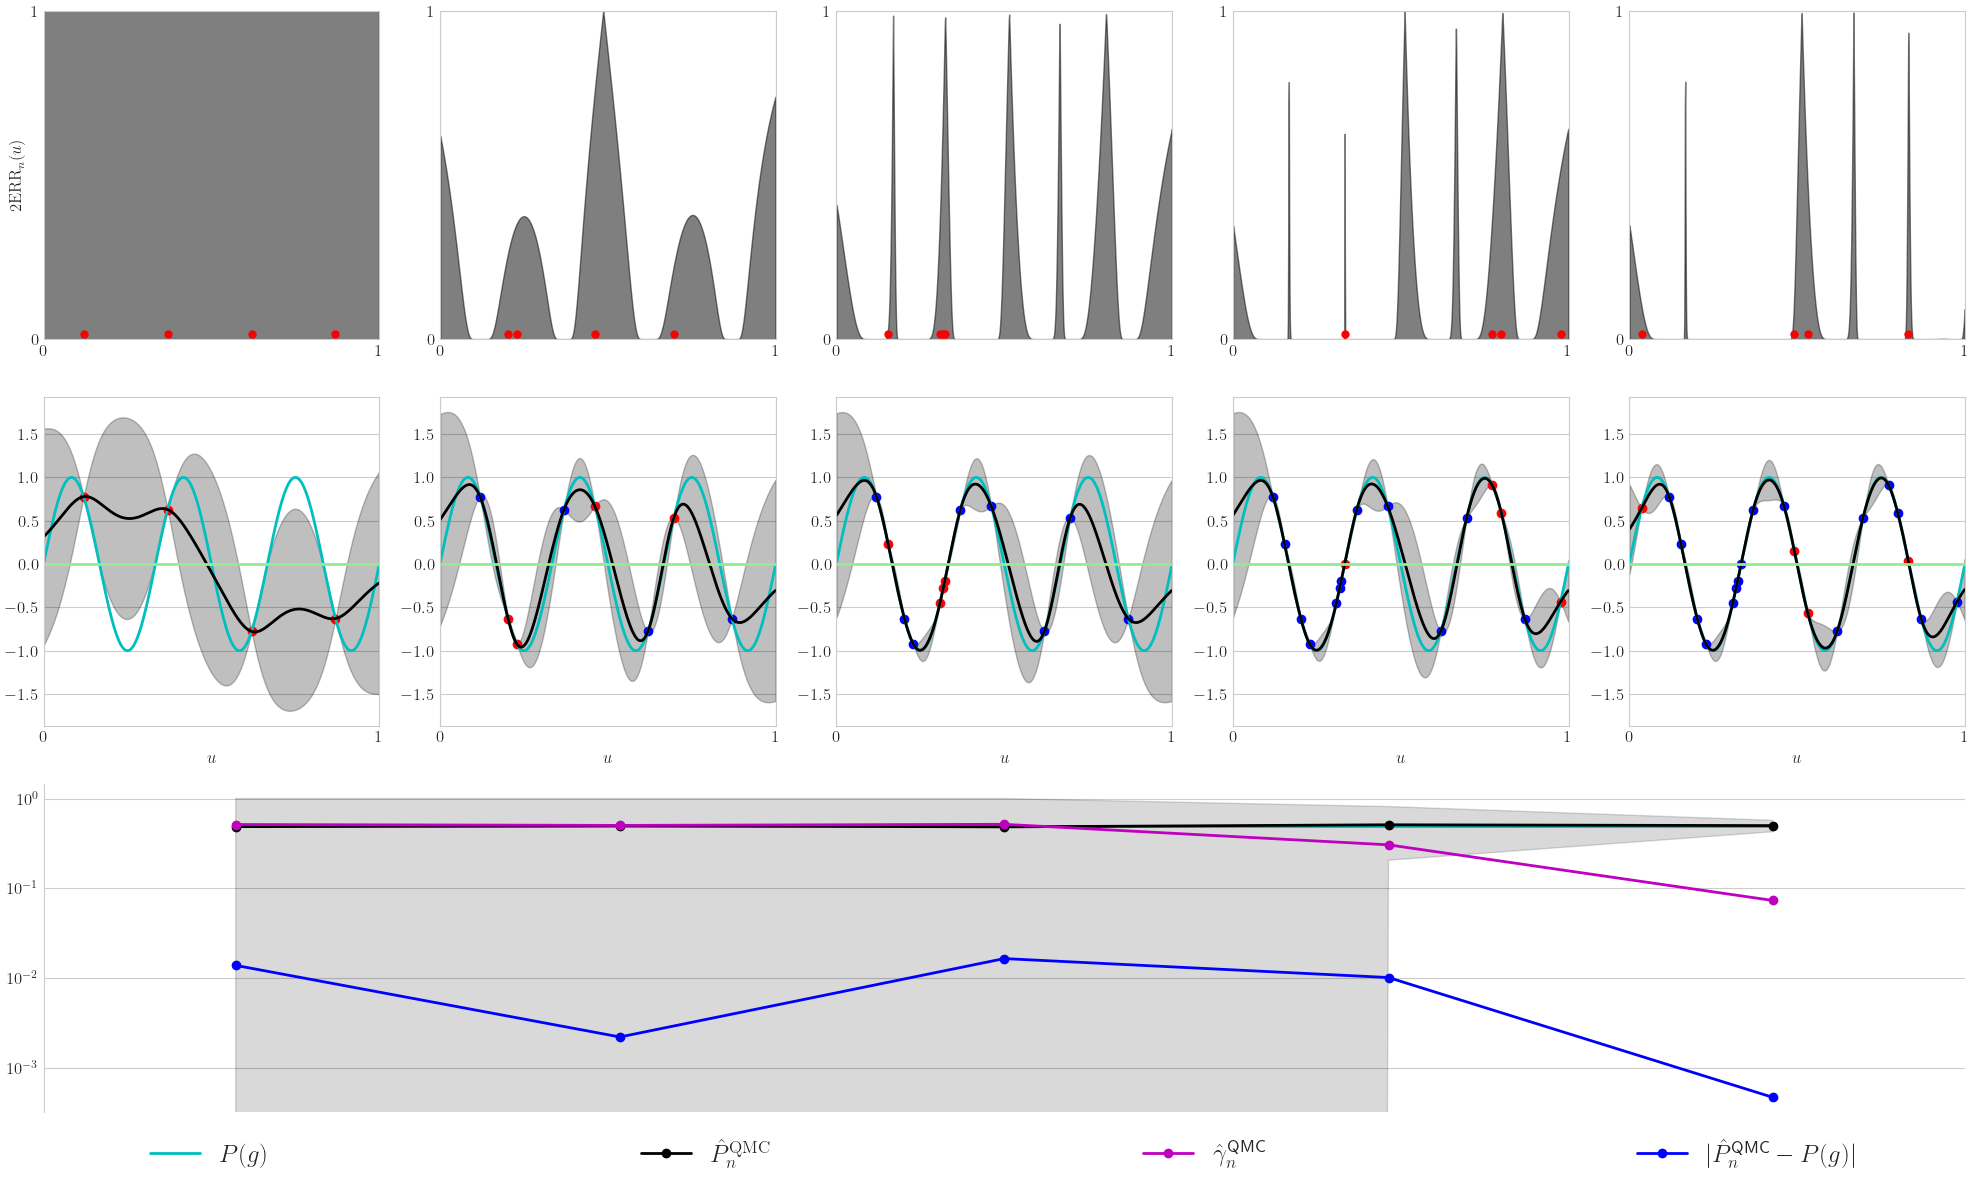

In [12]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Sin1d(qp.DigitalNetB2(1,seed=17),k=3),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 4,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 4,
    n_max = 20,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.01,.1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,10)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 100,
    gpytorch_use_gpu = False,
    verbose = 50,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/Sin1D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/Sin1D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Multimodal 2d Problem

reference approximation with d=2: 0.30208706855773926
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 1.45e+00
			covar_module.raw_outputscale...................... 2.92e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.02e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 1.49e+00
			covar_module.raw_outputscale...................... 3.70e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.32e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 1.53e+00
			covar_module.raw_outputscale...................... 4.24e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.43e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 1.58e+00
			covar_module.raw_outputscale...................... 4.66e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.48e+00
batch 1
	AR sampling with efficiency 7.6e-02, expect 211 draws: 144, 198, 
batch 2

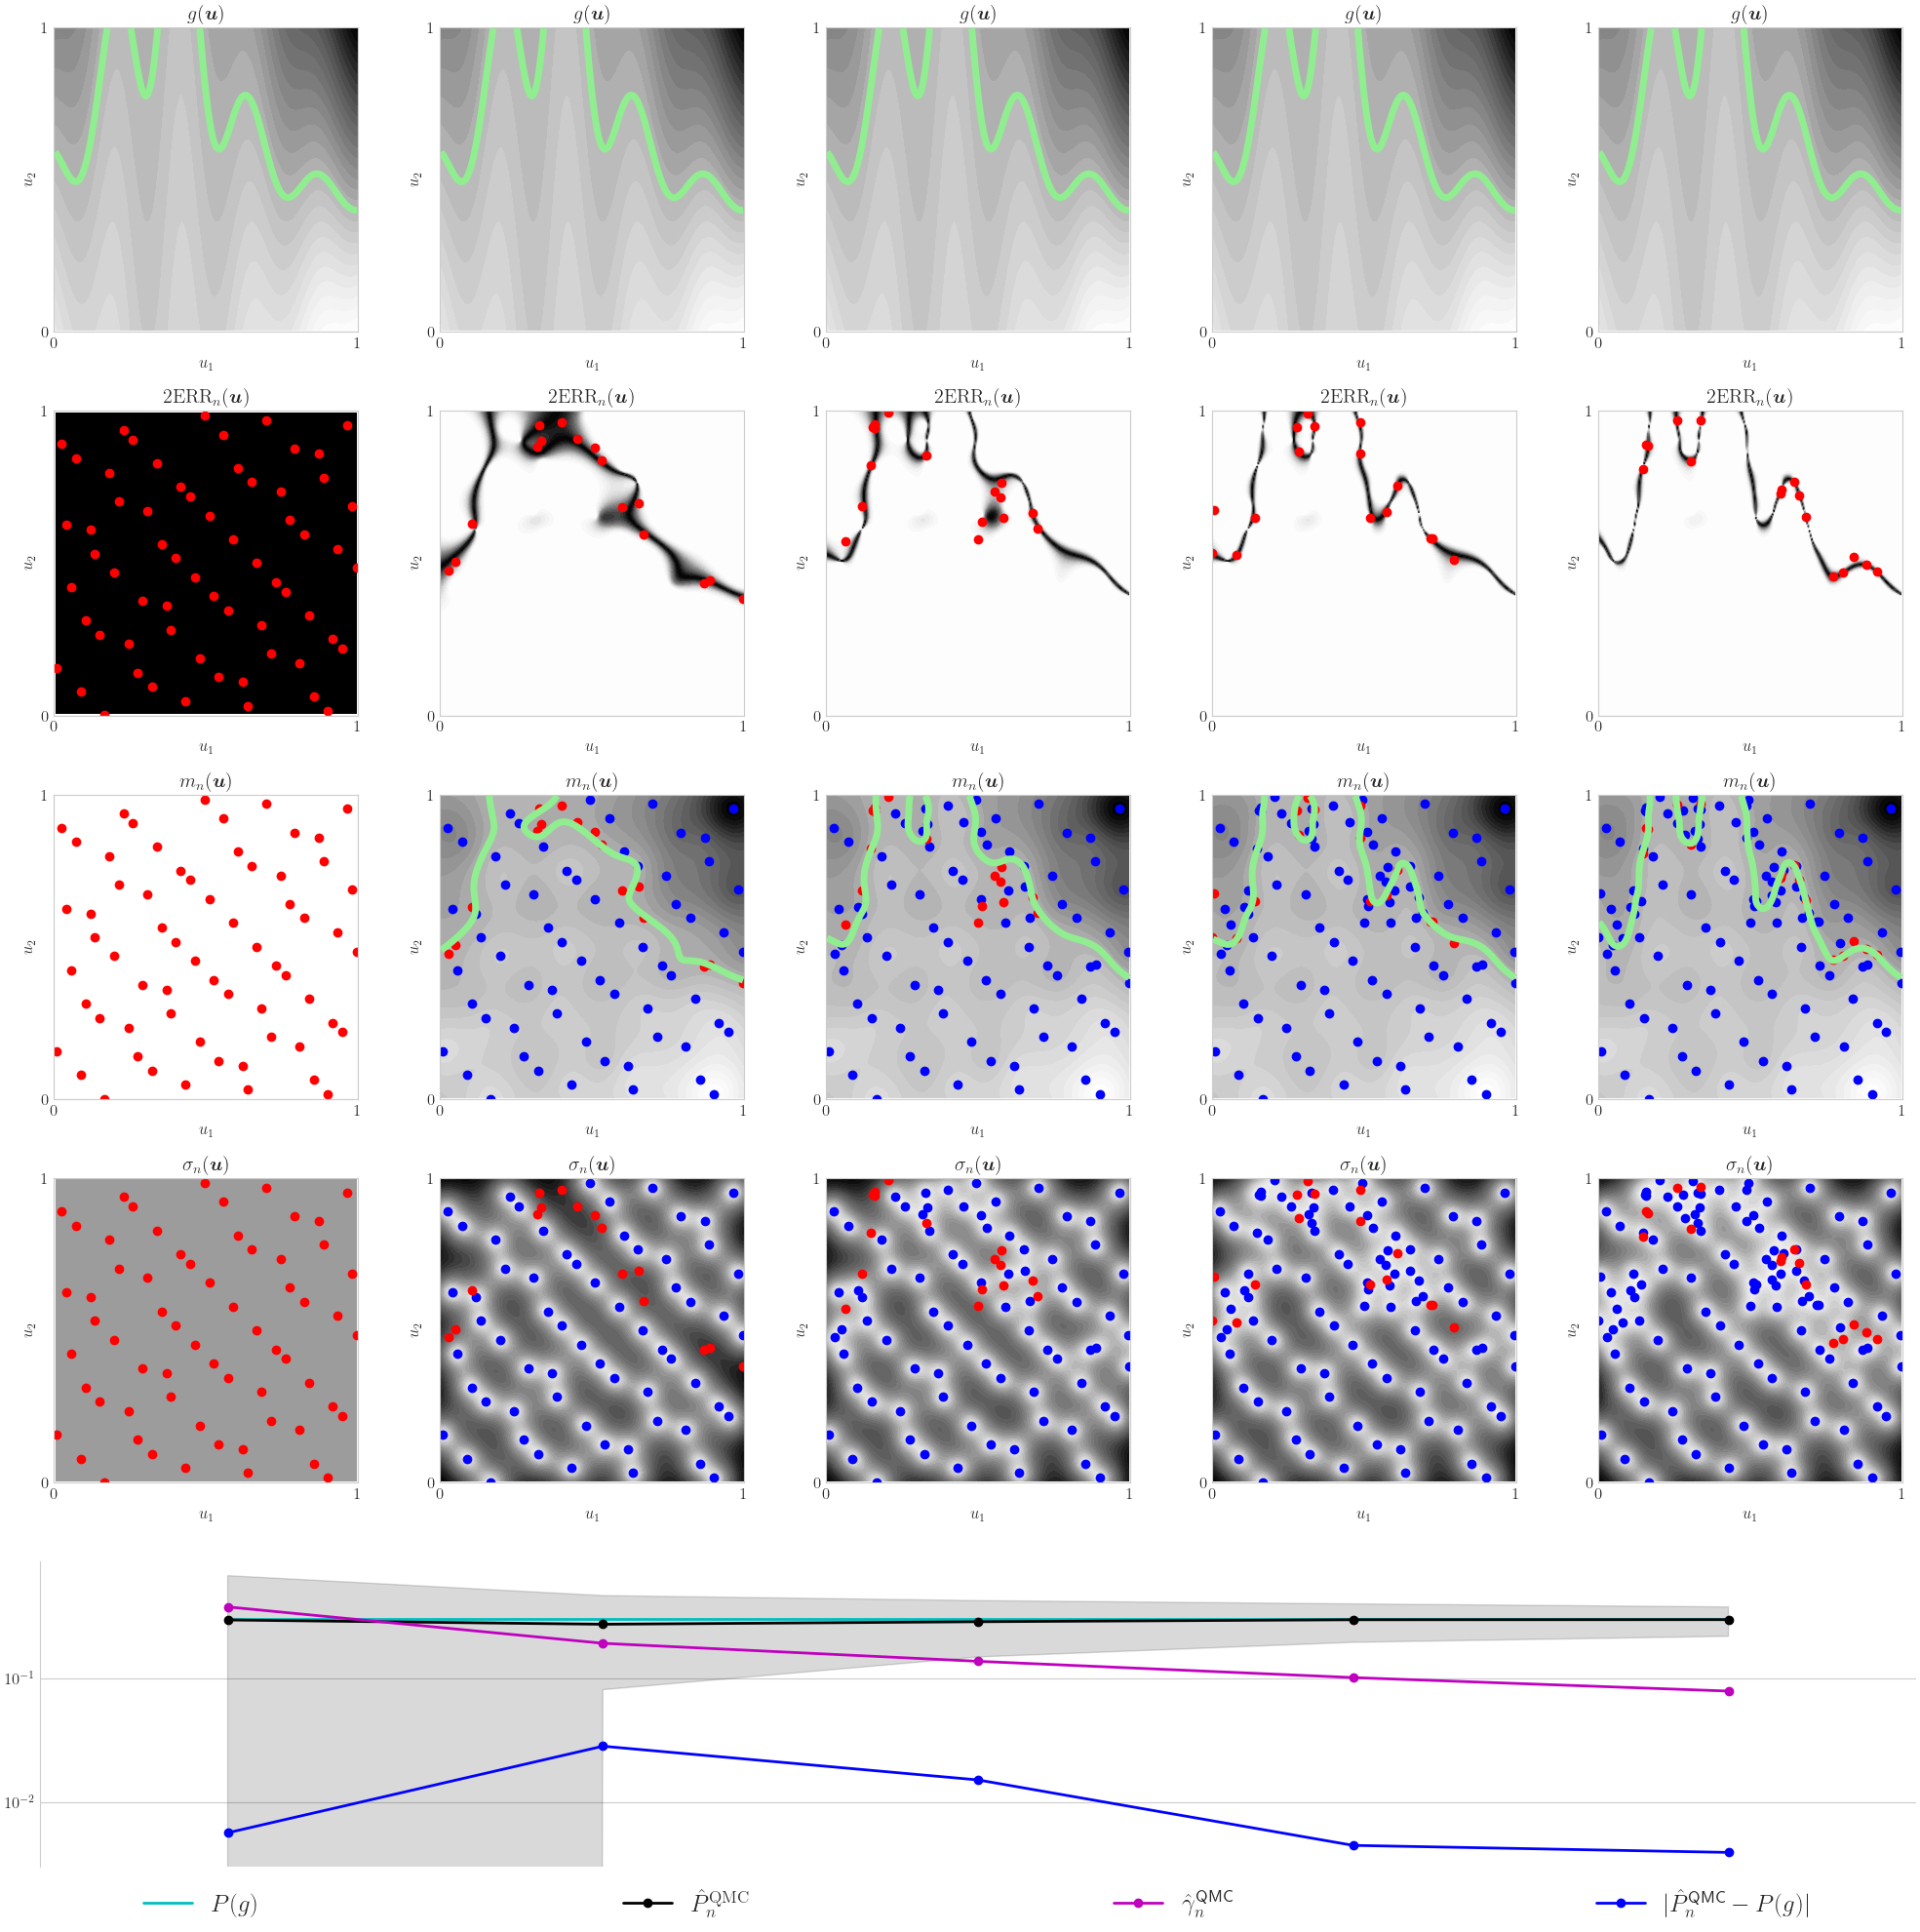

In [17]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Multimodal2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_max = 128,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.1,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/Multimodal2D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/Multimodal2D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Four Branch 2d Problem

reference approximation with d=2: 0.20872807502746582
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.89e+00
			covar_module.raw_outputscale...................... 3.88e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.50e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 3.63e+00
			covar_module.raw_outputscale...................... 4.78e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.44e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 4.17e+00
			covar_module.raw_outputscale...................... 5.36e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.04e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 4.59e+00
			covar_module.raw_outputscale...................... 5.80e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.48e+00
batch 1
	AR sampling with efficiency 9.0e-03, expect 1337 draws: 924, 1232, 
batch

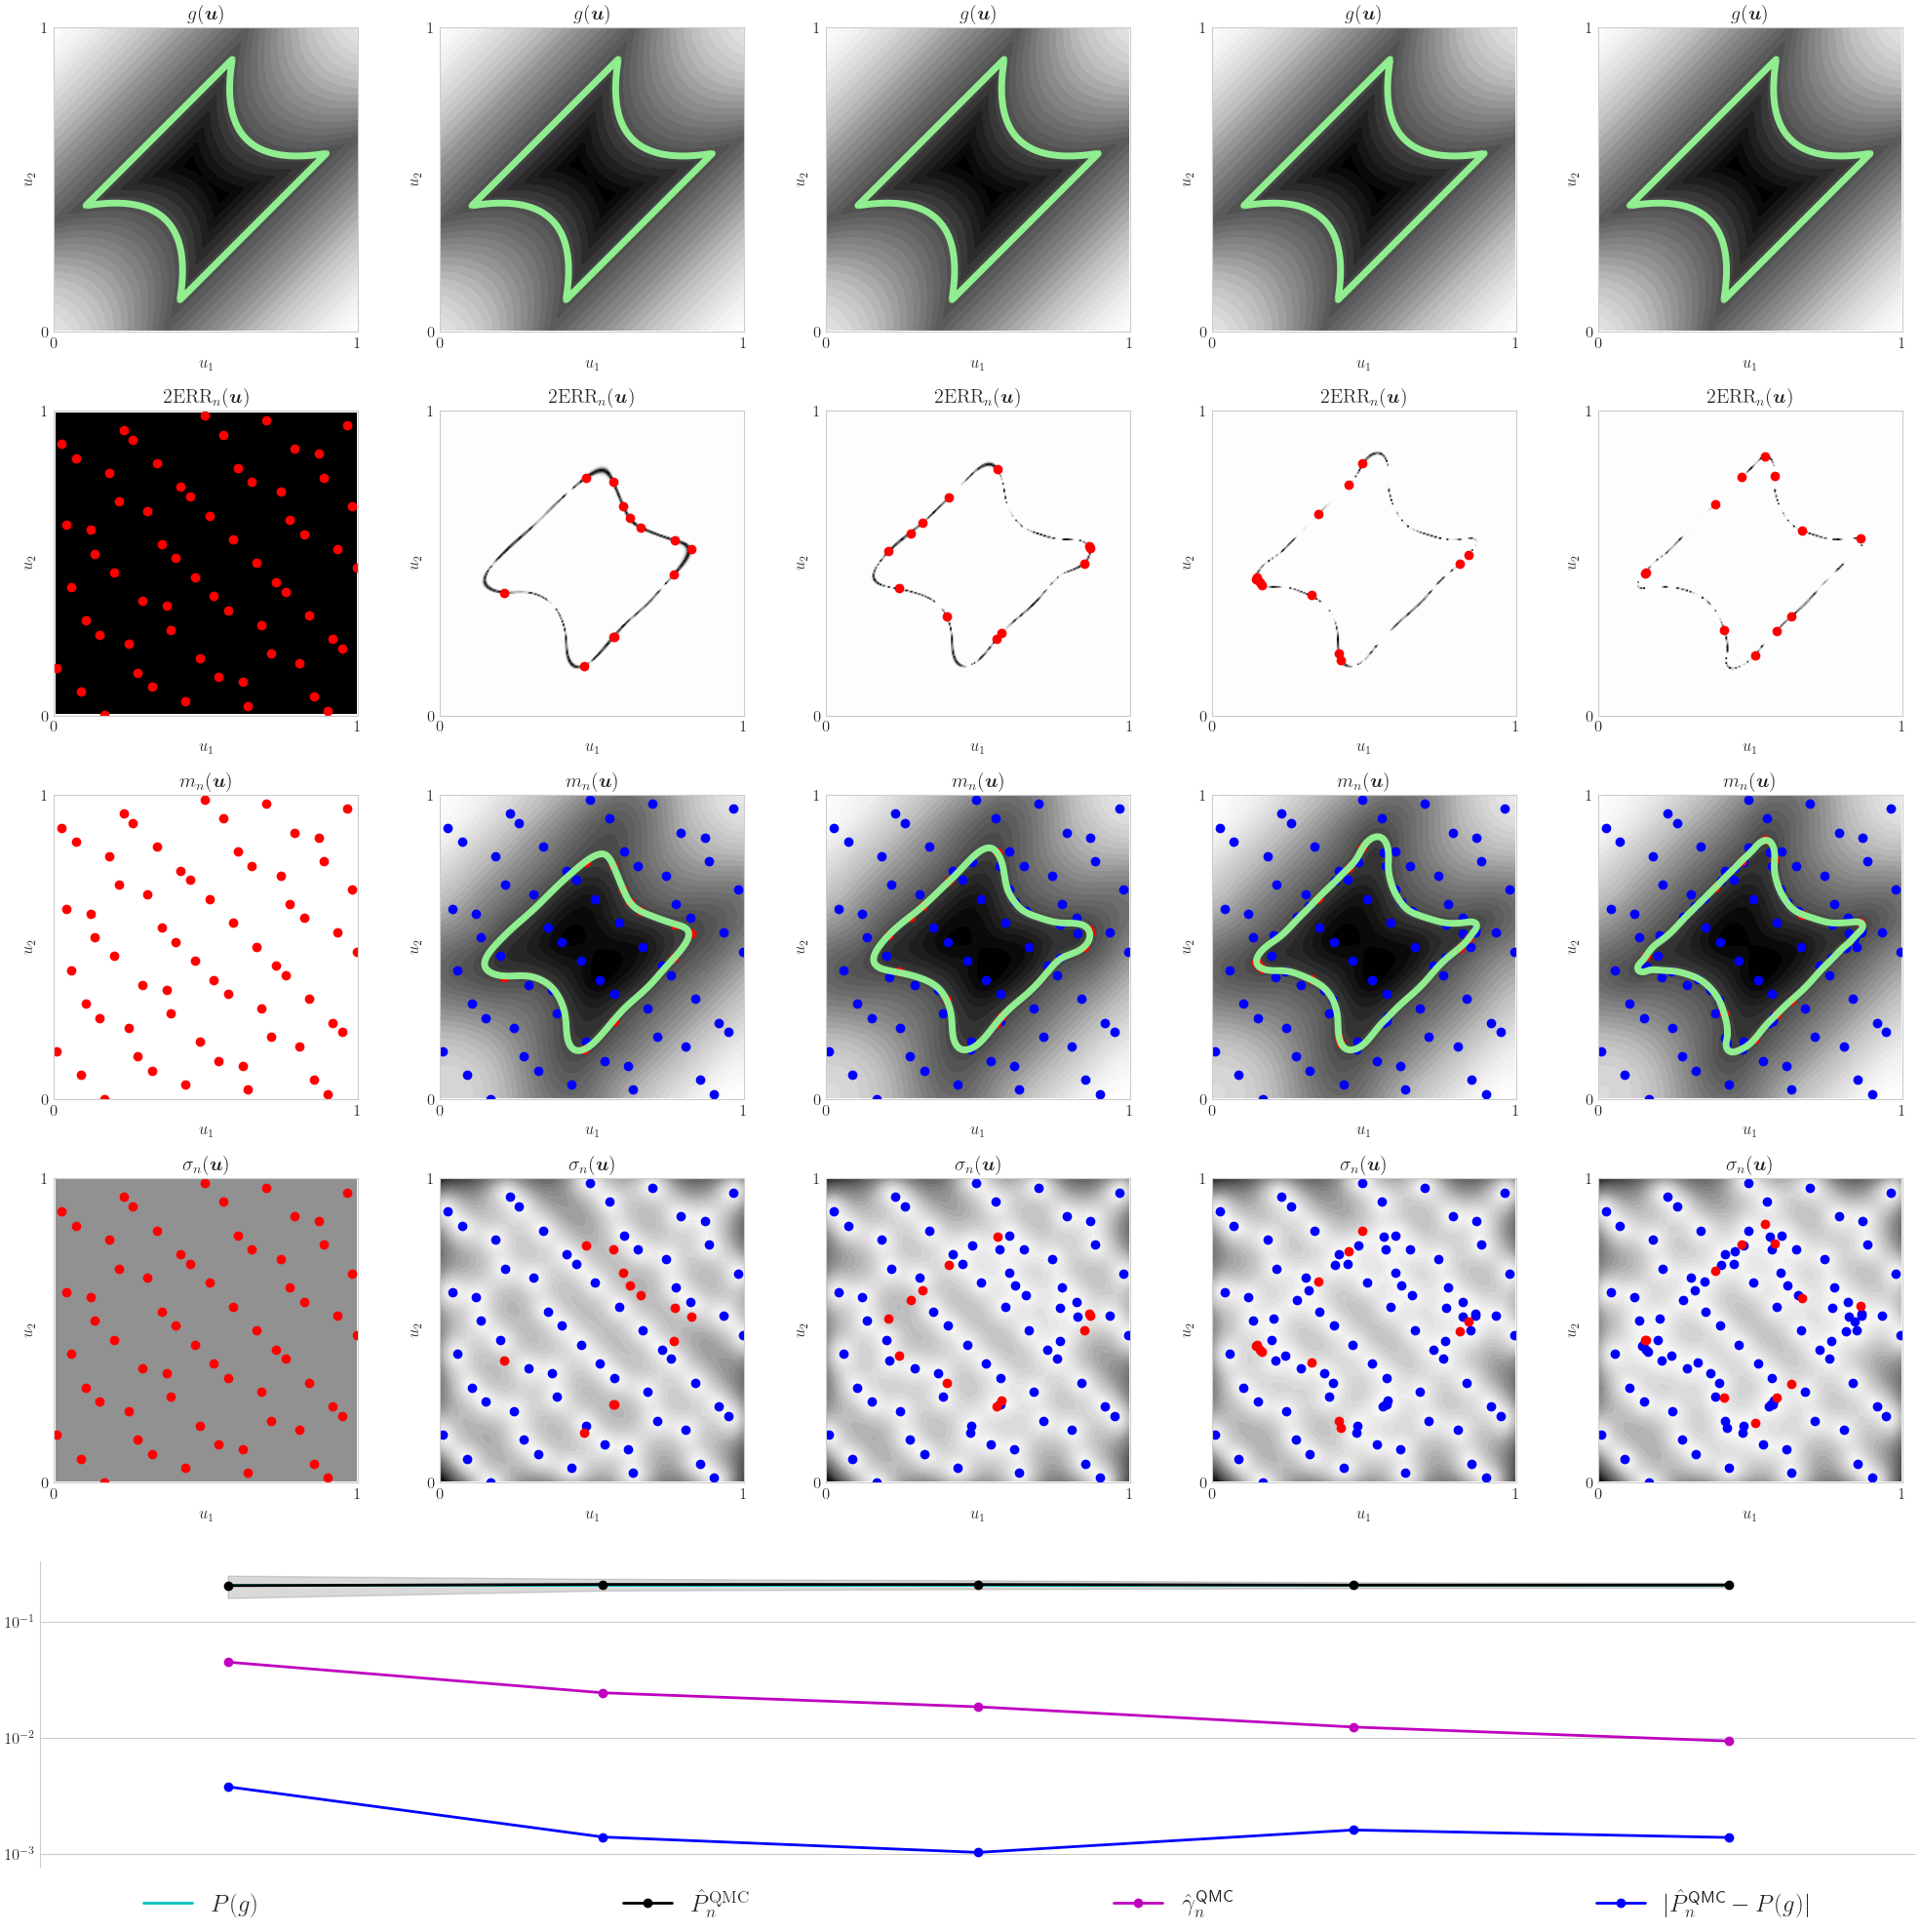

In [16]:
mcispfgp = qp.PFGPCI(
    integrand = qp.FourBranch2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 12,
    n_max = 200,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/FourBranch2D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/FourBranch2D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Ishigami 3d Problem

reference approximation with d=3: 0.16238808631896973
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.18e+00
			covar_module.raw_outputscale...................... 3.43e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.09e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 2.66e+00
			covar_module.raw_outputscale...................... 4.26e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.99e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 3.08e+00
			covar_module.raw_outputscale...................... 4.81e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.56e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 3.43e+00
			covar_module.raw_outputscale...................... 5.24e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.00e+00
batch 1
	AR sampling with efficiency 6.1e-03, expect 2626 draws: 1824, 
batch 2
	A

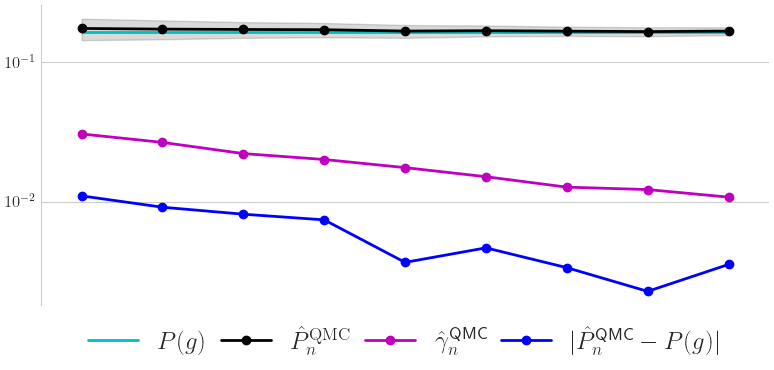

In [18]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Ishigami(qp.DigitalNetB2(3,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=False,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 128,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_max = 256,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/Ishigami3D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/Ishigami3D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Hartmann 6d Problem

reference approximation with d=6: 0.007382750511169434
batch 0
	gpytorch model fitting
		iter 50  of 150
			likelihood.noise_covar.raw_noise.................. 1.65e+00
			covar_module.raw_outputscale...................... 5.53e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.79e-01
		iter 100 of 150
			likelihood.noise_covar.raw_noise.................. 2.80e+00
			covar_module.raw_outputscale...................... 5.10e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.67e-01
		iter 150 of 150
			likelihood.noise_covar.raw_noise.................. 3.38e+00
			covar_module.raw_outputscale...................... 5.14e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.68e-01
batch 1
	AR sampling with efficiency 1.4e-03, expect 45088 draws: 31232, 35624, 
batch 2
	AR sampling with efficiency 2.1e-03, expect 30750 draws: 21312, 27306, 29304, 30969, 31635, 32301, 
batch 3
	AR sampling with efficiency 1.8e-03, expect 35103 draws: 24320, 32680, 36860, 38000, 
batch 4

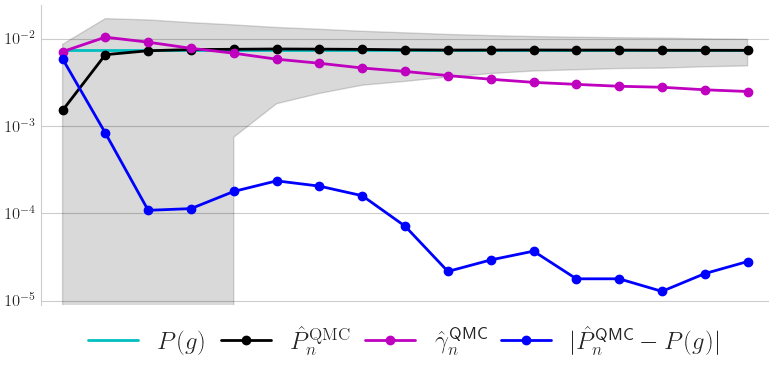

In [19]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Hartmann6d(qp.DigitalNetB2(6,seed=17)),
    failure_threshold = -2,
    failure_above_threshold=False,
    abs_tol = 2.5e-3,
    alpha = 1e-1,
    n_init = 512,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 64,
    n_max = 2500,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 150,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 50,
    n_ref_approx = 2**23,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/Hartmann6D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/Hartmann6D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Tsunami

In [6]:
import umbridge

In [7]:
!docker run --name tsunami -d -it -p 4242:4242 linusseelinger/model-exahype-tsunami:latest # https://um-bridge-benchmarks.readthedocs.io/en/docs/models/exahype-tsunami.html

447a7b6be4e6b844cc48d0cb8172dd65ed55f8f1307d4285ddab53b615fce462


In [9]:
ld_sampler = qp.DigitalNetB2(2,seed=7)
origin_distrib = qp.Uniform(ld_sampler,lower_bound=[-239,-339],upper_bound=[739,339])
umbridge_tsu_model = umbridge.HTTPModel('http://localhost:4242','forward')
umbridge_config = {'d': origin_distrib.d, 'level':1}
qmcpy_umbridge_tsu_model = qp.UMBridgeWrapper(origin_distrib,umbridge_tsu_model,umbridge_config,parallel=True)

In [10]:
class TsunamiMaxWaveHeightBouy1(qp.Integrand):
    # https://um-bridge-benchmarks.readthedocs.io/en/docs/models/exahype-tsunami.html#
    def __init__(self, qmcpy_umbridge_tsu_model):
        self.tsu_model = qmcpy_umbridge_tsu_model
        self.true_measure = self.sampler = self.tsu_model.true_measure
        assert self.tsu_model.d == 2
        super(TsunamiMaxWaveHeightBouy1,self).__init__(
            dimension_indv = 1,
            dimension_comb = 1,
            parallel = False,
            threadpool = False)
    def g(self, t):
        assert t.ndim==2 and t.shape[1]==self.d
        y = self.tsu_model.g(t)
        y_buoy1_height = 1000*y[:,1] # max wave height at buoy (meters SSHA)
        height_above_thresh = y_buoy1_height
        return height_above_thresh
tmwhb1 = TsunamiMaxWaveHeightBouy1(qmcpy_umbridge_tsu_model)

batch 0
	gpytorch model fitting
		iter 1000 of 1000
			likelihood.noise_covar.raw_noise.................. 1.17e+00
			mean_module.raw_constant.......................... -2.04e+00
			covar_module.raw_outputscale...................... 2.47e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.44e+00
batch 1
	AR sampling with efficiency 9.0e-03, expect 890 draws: 616, 1078, 
batch 2
	AR sampling with efficiency 6.1e-03, expect 1307 draws: 904, 1356, 
batch 3
	AR sampling with efficiency 4.2e-03, expect 1884 draws: 1304, 1956, 
batch 4
	AR sampling with efficiency 1.1e-02, expect 705 draws: 488, 549, 
batch 5
	AR sampling with efficiency 3.2e-03, expect 2524 draws: 1752, 
batch 6
	AR sampling with efficiency 2.1e-03, expect 3901 draws: 2704, 
batch 7
	AR sampling with efficiency 1.2e-03, expect 6932 draws: 4808, 5409, 6010, 
batch 8
	AR sampling with efficiency 9.6e-04, expect 8294 draws: 5752, 7190, 
PFGPCIData (AccumulateData Object)
    solution        0.063
    error_bound     0

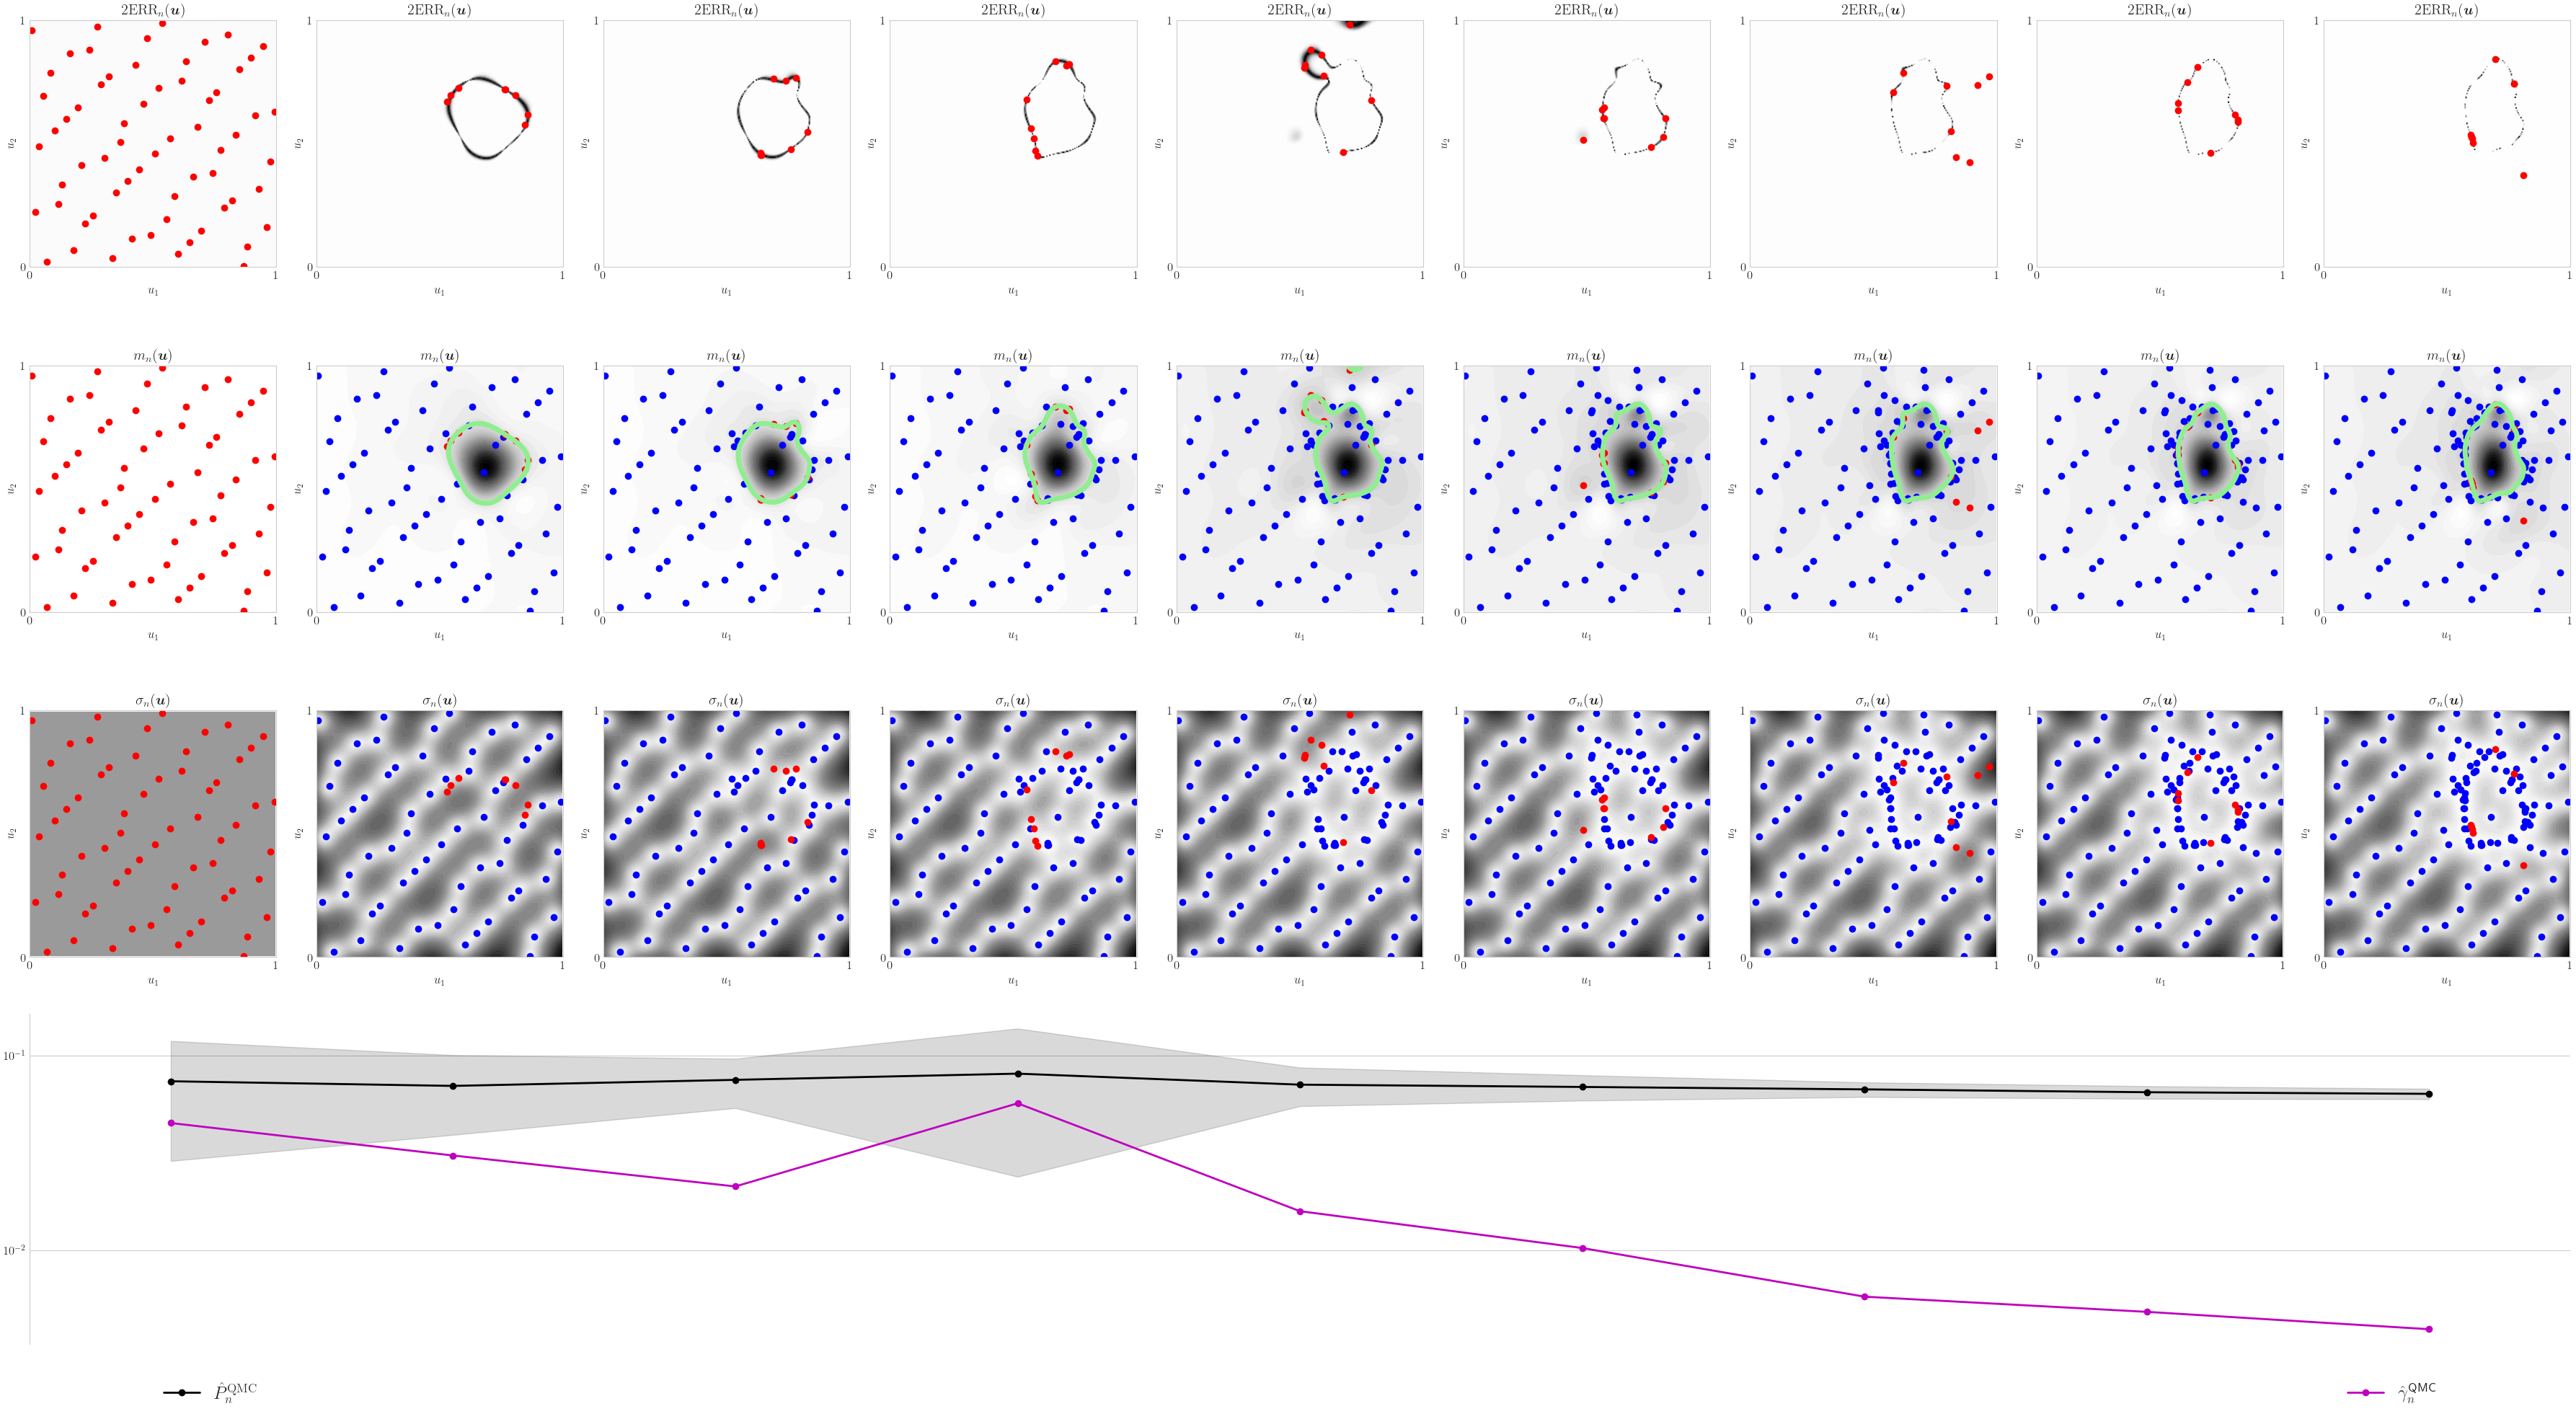

In [11]:
mcispfgp = qp.PFGPCI(
    integrand = tmwhb1,
    failure_threshold = 3,
    failure_above_threshold=True,
    abs_tol = 1e-3,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 8,
    n_max = 128,
    n_approx = 2**20,
    gpytorch_prior_mean = gpytorch.means.ConstantMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.1,1)),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,1)),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-10)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 1000,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 1000,
    n_ref_approx = 0)
solution,data = mcispfgp.integrate(seed=11,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("prob_failure_gp_ci_plots/Tsunami2D/df.csv",index=False)
fig.savefig("prob_failure_gp_ci_plots/Tsunami2D/fig.png",dpi=256,transparent=True,bbox_inches="tight")

In [5]:
!docker rm -f tsunami

tsunami
